<a href="https://colab.research.google.com/github/JakobRobnik/MicroCanonicalHMC/blob/master/intro_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Getting started - MCHMC sampling from a Standard Gaussian target distribution**

## Setup

First, let's import the MCHMC code.

In [1]:
!git clone https://github.com/JakobRobnik/MicroCanonicalHMC.git

Cloning into 'MicroCanonicalHMC'...
remote: Enumerating objects: 562, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 562 (delta 65), reused 60 (delta 34), pack-reused 460
Receiving objects: 100% (562/562), 794.03 KiB | 9.34 MiB/s, done.
Resolving deltas: 100% (360/360), done.


We will be using jax, as it can automatically compute gradients.

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from MicroCanonicalHMC.mchmc import Sampler

In this example we will sample from a standard Gaussian target. Let's define the negative log density:

In [3]:
nlogp = lambda x: 0.5*jnp.sum(jnp.square(x))

and get the gradient with jax:

In [4]:
grad_nlogp = jax.grad(nlogp)


The target is a class with functions `nlogp`, `grad_nlogp` and `transform`. Some common targets are implemented in `targets.py`.
Let's here define the standard Gaussian target:

In [16]:
class StandardGaussian():
  
  def __init__(self, d):
    self.d = d
  
  def nlogp(self, x):
     return nlogp(x)

  def grad_nlogp(self, x):
     return grad_nlogp(x)

  def transform(self, x):
    return x[:2] 
    #return x

  def prior_draw(self, key):
    """Args: jax random key
       Returns: one random sample from the prior"""

    return jax.random.normal(key, shape = (self.d, ), dtype = 'float64') * 4

`transform` is useful when the dimensionality is high and storing all of the samples becomes memory intesive. We are ususally only iterested in some lower dimensional marginal distribution. `transform` is used in those cases as a map to the lower dimensional space of interest. As an illustration, here we are only interested in the first two components $x_1$ and $x_2$. If not needed it can just be set to the identity (commented out line).

`prior_draw` is not a required attribute. By default it is used to initialize the chain. If not defined, we should pass the initial condition to the `sample` function by hand.

Let's sample from a $d = 1000$ Standard Gaussian target. We create a mchmc Sampler class by passing it the desired target distribution:

In [24]:
MCHMC = Sampler(StandardGaussian(d = 1000))

We used the default Langevin-like momentum decoherence mechanism (`generalized= True`) and the Minimal Norm integrator of the dynamics (`integrator= 'MN'`).

MCHMC has two hyperparameters, the integration step-size $ϵ$ and the momentum decoherence scale $L$. Let's use a short prerun to tune them:

In [25]:
MCHMC.tune_hyperparameters()

Sampler now has the hyperparameter attributes:

In [26]:
print('eps: {0}, L: {1}'.format(MCHMC.eps, MCHMC.L))

eps: 51.562861810543794, L: 17.772669402631696


We can now run the sampler. Let's get 5000 samples.

In [28]:
samples, weights = MCHMC.sample(5000)

The sampler returns the samples and the associated weights.

In [29]:
print(jnp.shape(samples))
print(jnp.shape(weights))

(5000, 2)
(5000,)


Let's plot the one dimensional marginal distribution along the $x_1$ coordinate.

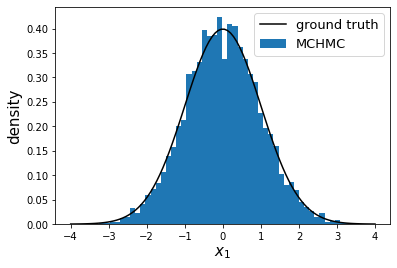

In [30]:
plt.hist(samples[:, 0], bins = 50, weights = weights, density = True, label = 'MCHMC')

from scipy.stats import norm

t = jnp.linspace(-4, 4, 100)
plt.plot(t, norm.pdf(t), color = 'black', label = 'ground truth')

plt.xlabel(r'$x_1$', fontsize = 15)
plt.ylabel('density', fontsize = 15)
plt.legend(fontsize = 13)
plt.show()

Alternatively, we can avoid the weights for ploting purposes and resample according to the weights:

In [31]:
x1 = np.random.choice(samples[:, 0], 50000, p= weights / np.sum(weights))

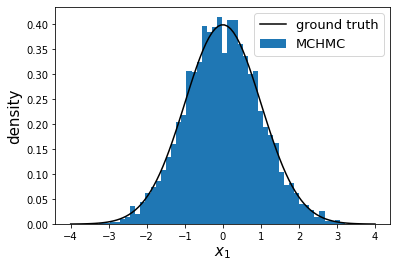

In [32]:
plt.hist(x1, bins = 50, density = True, label = 'MCHMC')

plt.plot(t, norm.pdf(t), color = 'black', label = 'ground truth')

plt.xlabel(r'$x_1$', fontsize = 15)
plt.ylabel('density', fontsize = 15)
plt.legend(fontsize = 13)
plt.show()